In [27]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import norm
import scipy.integrate as integrate
from operator import mul
from functools import reduce

In [28]:
# Generate data
np.random.seed(2)
size = 100
mu = np.random.normal(0,1,size=size)
sigma = 1
X_obs = np.random.normal(mu,sigma,size=size)



In [29]:
# Specify model
basic_model = pm.Model()
with basic_model:
    sigma = 1
    mu = pm.Normal('mu',mu=0,sd=sigma)
    X = pm.Normal('X',mu=mu,sd=sigma,observed=X_obs)

In [30]:
# Draw samples from posterior
nr_of_samples = 100
with basic_model:
    trace = pm.sample(nr_of_samples,chains=1)
    samples_mu = trace['mu']
    samples_X = np.random.normal(samples_mu,1,size=nr_of_samples)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu]
100%|██████████| 600/600 [00:00<00:00, 2664.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


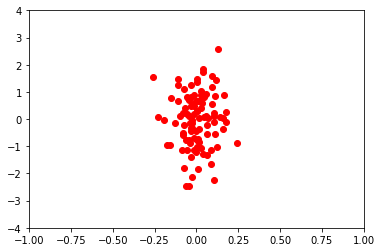

In [31]:
plt.plot(samples_mu, samples_X, 'ro')
plt.axis([-1, 1, -4, 4])
plt.show()


In [59]:
## Set parameters

# model parameters
prior_mean_mu = 0
prior_sigma_mu = 1
prior_sigma_x = 1

# plot parameters
resolution_joint_mu = 201
resolution_joint_x = 201
range_joint_mu_upper = 1.5
range_joint_mu_lower = -1.5
range_joint_x_upper = 3
range_joint_x_lower = -3


In [33]:
## Calculate joint posterior distribution
def prior_mu(mu):
    density = norm.pdf(mu, loc=prior_mean_mu, scale=prior_sigma_mu)
    return density

def likelihood_x(x,mu):
    density = norm.pdf(x, loc=mu, scale=prior_sigma_x)
    return density

def likelihood_X(X,mu): 
    likelihoods = [likelihood_x(point,mu) for point in X]
    res = reduce(mul, likelihoods, 1)
    return res

def likelihood_times_prior_mu(X,mu):
    return likelihood_X(X,mu) * prior_mu(mu)

def prior_X(X):
    res = integrate.quad(lambda mu: likelihood_times_prior_mu(X,mu),a=-np.inf,b=np.inf)[0]
    return res

def joint_posterior(x,mu,X):
    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
    return res

def joint_posterior_without_normalizing_constant(x,mu,X):
    res = likelihood_x(x,mu) * likelihood_X(X,mu) * prior_mu(mu)
    return res

def posterior_marginal_x_without_normalizing_constant(x,X):
    res = integrate.quad(lambda mu:joint_posterior_without_normalizing_constant(mu=mu,X=X,x=x),a=-np.inf,b=np.inf)[0]
    return res

def posterior_marginal_mu(mu,X):
    res = likelihood_X(X,mu) * prior_mu(mu) / prior_X(X)
    return res

def posterior_marginal_mu_without_normalizing_constant(mu,X):
    res = likelihood_X(X,mu) * prior_mu(mu) 
    return res

In [34]:
## Improve performance of calculations

def prior_mu_vectorized(mu_vector):
    res = [prior_mu(mu) for mu in mu_vector]
    return res

def likelihood_X_vectorized(X,mu_vector):
    res = [likelihood_X(X,mu) for mu in mu_vector]
    return res

def likelihood_x_vectorized(x_vector,mu_vector):
    res = [likelihood_x(x,mu) for x in x_vector for mu in mu_vector]
    res = np.reshape(np.asarray(res),(resolution_joint_x,resolution_joint_mu))
    return res

def joint_posterior_without_normalizing_constant_vectorized(x_vector,mu_vector,X):
    res = np.multiply(prior_mu_vectorized(mu_vector),likelihood_X_vectorized(X,mu_vector))
    res = np.multiply(likelihood_x_vectorized(x_vector,mu_vector),res)
    return res

In [61]:
## Build grid for plotting joint posterior distribution

mu_plot = linspace(range_joint_mu_lower,range_joint_mu_upper,resolution_joint_mu)
x_plot = linspace(range_joint_x_lower,range_joint_x_upper,resolution_joint_x)

grid = joint_posterior_without_normalizing_constant_vectorized(x_plot,mu_plot,X_obs)

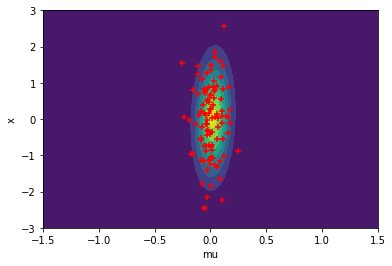

In [74]:
cnt = contourf(mu_plot, x_plot, grid)
plt.xlabel('mu')
plt.ylabel('x')
plt.ylim((range_joint_x_lower,range_joint_x_upper))
plt.xlim((range_joint_mu_lower,range_joint_mu_upper))
_ = plt.scatter(samples_mu, samples_X,marker='+',c='r')